# Evidently Monitoring Dashboard

This notebook provides an interactive dashboard for monitoring data drift and model performance using Evidently.

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Import Evidently monitoring (try v2 first as it's more compatible)
evidently_monitor = None
monitor_version = None

try:
    from evidently_monitoring_v2 import FearGreedEvidentlyMonitorV2
    evidently_monitor = FearGreedEvidentlyMonitorV2
    monitor_version = "v2"
    print("✅ Evidently monitoring V2 imported successfully")
except ImportError as e:
    print(f"⚠️ Evidently monitoring V2 import failed: {e}")
    try:
        from evidently_monitoring import FearGreedEvidentlyMonitor
        evidently_monitor = FearGreedEvidentlyMonitor
        monitor_version = "v1"
        print("✅ Evidently monitoring V1 imported successfully")
    except ImportError as e2:
        print(f"❌ Both Evidently imports failed: {e2}")
        print("💡 Will use basic monitoring without Evidently")
        evidently_monitor = None
        monitor_version = "manual"

print(f"🔧 Using monitor version: {monitor_version}")

In [ ]:
# Initialize monitoring environment
print("📊 Evidently monitoring environment initialized")
print(f"🔧 Monitor version: {monitor_version}")
print(f"📁 Working directory: {os.getcwd()}")

# Create monitoring directory if it doesn't exist
monitoring_dir = Path("monitoring")
monitoring_dir.mkdir(exist_ok=True)
print(f"📂 Monitoring directory: {monitoring_dir.resolve()}")

In [11]:
# Load and examine the new dataset
print("📊 Loading new dataset...")
new_data = pd.read_csv('Data_new.csv')

print(f"Dataset shape: {new_data.shape}")
print(f"Date range: {new_data['Date'].min()} to {new_data['Date'].max()}")
print(f"Columns: {list(new_data.columns)}")

# Display basic info about the new dataset
print("\n📈 Dataset Overview:")
print(new_data.info())
print("\n📊 First few rows:")
display(new_data.head())

📊 Loading new dataset...
Dataset shape: (1101, 23)
Date range: 1/10/22 to 9/9/24
Columns: ['Date', 'SPY_Price', 'SPY_Volatility', 'SPY_Volume', 'QQQ_Price', 'QQQ_Volatility', 'QQQ_Volume', 'GLD_Price', 'GLD_Volatility', 'GLD_Volume', 'HYG_Price', 'HYG_Volatility', 'HYG_Volume', 'VIX_Price', 'VIX_Fear_Level', 'TLT_Price', 'TLT_Volume', 'TLT_Volatility', 'CPIAUCSL', 'HOUST', 'BAMLH0A0HYM2', 'DGS10', 'UMCSENT']

📈 Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1101 entries, 0 to 1100
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            1101 non-null   object 
 1   SPY_Price       1101 non-null   float64
 2   SPY_Volatility  1101 non-null   float64
 3   SPY_Volume      1101 non-null   int64  
 4   QQQ_Price       1101 non-null   float64
 5   QQQ_Volatility  1101 non-null   float64
 6   QQQ_Volume      1101 non-null   int64  
 7   GLD_Price       1101 non-null   float64
 8   GLD_V

,Date,SPY_Price,SPY_Volatility,SPY_Volume,QQQ_Price,QQQ_Volatility,QQQ_Volume,GLD_Price,GLD_Volatility,GLD_Volume,...,VIX_Price,VIX_Fear_Level,TLT_Price,TLT_Volume,TLT_Volatility,CPIAUCSL,HOUST,BAMLH0A0HYM2,DGS10,UMCSENT
0,4/1/21,400.61,0.135584,99682876,324.57,0.269009,55685602,161.98,0.145822,7105228,...,17.330000,Normal,137.51,14885947,0.149274,266.625,1495,3.33,1.69,88.3
1,4/5/21,406.36,0.130192,91684764,331.05,0.272371,42172475,161.92,0.145895,6163799,...,17.910000,Normal,136.91,8242978,0.149656,266.625,1495,3.25,1.73,88.3
2,4/6/21,406.12,0.127569,62020953,330.82,0.245731,33537210,163.22,0.141590,6761166,...,18.120001,Normal,137.84,9282395,0.149433,266.625,1495,3.25,1.67,88.3
3,4/7/21,406.59,0.120683,55836280,331.62,0.209415,32046381,162.76,0.122205,5436014,...,17.160000,Normal,136.88,11052827,0.142002,266.625,1495,3.22,1.68,88.3
4,4/8/21,408.52,0.120188,57863114,335.08,0.209654,29940799,164.51,0.126524,6574524,...,16.950001,Normal,138.01,7847918,0.145445,266.625,1495,3.21,1.64,88.3


In [12]:
# Load holdout datasets for comparison
print("📊 Loading holdout datasets for monitoring...")

old_holdout = pd.read_csv('data/old_future_holdout_20pct.csv')
new_holdout = pd.read_csv('data/new_future_holdout_20pct.csv')

print(f"Old holdout: {old_holdout.shape[0]} samples")
print(f"New holdout: {new_holdout.shape[0]} samples")
print(f"Old holdout date range: {old_holdout['Date'].min()} to {old_holdout['Date'].max()}")
print(f"New holdout date range: {new_holdout['Date'].min()} to {new_holdout['Date'].max()}")

# Display sample comparison
print("\n📊 Sample Data Comparison:")
print("Old Holdout Sample:")
display(old_holdout.head(3))
print("New Holdout Sample:")
display(new_holdout.head(3))

📊 Loading holdout datasets for monitoring...
Old holdout: 223 samples
New holdout: 221 samples


TypeError: '<=' not supported between instances of 'str' and 'float'

In [ ]:
# Run Evidently monitoring pipeline
print("🚀 Starting Evidently monitoring pipeline...")

if evidently_monitor and monitor_version != "manual":
    try:
        # Initialize monitor
        monitor = evidently_monitor()
        print(f"✅ Using Evidently Monitor {monitor_version}")
        
        # Run complete monitoring pipeline
        print("🔍 Running complete monitoring pipeline...")
        monitoring_results = monitor.run_complete_monitoring()
        
        print(f"✅ Monitoring pipeline completed successfully!")
        print(f"📊 Results: {len(monitoring_results.get('saved_files', {}))} reports generated")
        
        # Display key findings
        if monitoring_results.get('alerts'):
            print("\n⚠️ ALERTS:")
            for alert in monitoring_results['alerts']:
                print(f"   {alert}")
        else:
            print("\n✅ No significant issues detected in monitoring")
            
    except Exception as e:
        print(f"❌ Error running Evidently monitoring: {e}")
        print("⚠️ Check Evidently installation and data files")
        monitoring_results = None
        
else:
    print("⚠️ Running manual monitoring - Evidently not available")
    monitoring_results = None
    
    # Basic manual monitoring
    print("📊 Basic data comparison:")
    print(f"   Old holdout samples: {len(old_holdout)}")
    print(f"   New holdout samples: {len(new_holdout)}")
    print(f"   New dataset samples: {len(new_data)}")
    
    # Check for basic data quality
    old_missing = old_holdout.isnull().sum().sum()
    new_missing = new_holdout.isnull().sum().sum()
    print(f"   Missing values - Old: {old_missing}, New: {new_missing}")

print(f"\n🎯 Monitoring completed!")
print(f"📁 Check ./monitoring/ directory for detailed reports")

In [ ]:
# Display monitoring results and visualizations
print("📊 Monitoring Results Summary")
print("=" * 50)

if 'monitoring_results' in locals() and monitoring_results:
    # Display drift summary
    if 'drift_summary' in monitoring_results:
        drift_summary = monitoring_results['drift_summary']
        print(f"📈 Data Drift Analysis:")
        print(f"   Drift Percentage: {drift_summary.get('drift_percentage', 0):.2f}%")
        print(f"   Overall Drift Detected: {'Yes' if drift_summary.get('overall_drift_detected') else 'No'}")
    
    # Display model performance
    if 'model_performance' in monitoring_results:
        print(f"\n🤖 Model Performance:")
        for model_name, metrics in monitoring_results['model_performance'].items():
            print(f"   {model_name}:")
            for metric_name, value in metrics.items():
                if isinstance(value, (int, float)) and metric_name != 'samples':
                    print(f"     {metric_name}: {value:.4f}")
                elif metric_name == 'samples':
                    print(f"     samples: {value}")
    
    # Display file locations
    if 'saved_files' in monitoring_results:
        print(f"\n📁 Generated Reports:")
        for file_type, file_path in monitoring_results['saved_files'].items():
            print(f"   {file_type}: {os.path.basename(file_path)}")
    
    # Display alerts
    if monitoring_results.get('alerts'):
        print(f"\n⚠️ Alerts:")
        for alert in monitoring_results['alerts']:
            print(f"   {alert}")
    
    print(f"\n✅ All monitoring reports available in ./monitoring/ directory")
    print(f"🌐 View detailed HTML reports by opening the generated files")
    
else:
    print("ℹ️ Evidently monitoring results not available")
    print("📊 Check the basic data comparison visualizations below")
    
    # Display basic statistics when Evidently is not available
    print(f"\n📈 Basic Data Statistics:")
    print(f"   Old holdout: {len(old_holdout)} samples")
    print(f"   New holdout: {len(new_holdout)} samples") 
    print(f"   New dataset: {len(new_data)} samples")
    
    # Check for common columns and show basic comparison
    common_numerical = ['SPY_Price', 'VIX_Price', 'QQQ_Price', 'SPY_Volatility']
    available_numerical = [col for col in common_numerical 
                          if col in old_holdout.columns and col in new_holdout.columns]
    
    if available_numerical:
        print(f"\n📊 Feature Comparison (first 3 features):")
        for col in available_numerical[:3]:
            old_mean = old_holdout[col].mean()
            new_mean = new_holdout[col].mean()
            change_pct = ((new_mean - old_mean) / old_mean * 100) if old_mean != 0 else 0
            print(f"   {col}: {old_mean:.2f} → {new_mean:.2f} ({change_pct:+.1f}%)")
    
    print(f"\n💡 To get detailed Evidently reports, ensure Evidently is properly installed")
    print(f"💡 Run: pip install evidently")

## Quick Data Comparison

Below is a quick comparison between the old and new holdout datasets to understand the data changes.

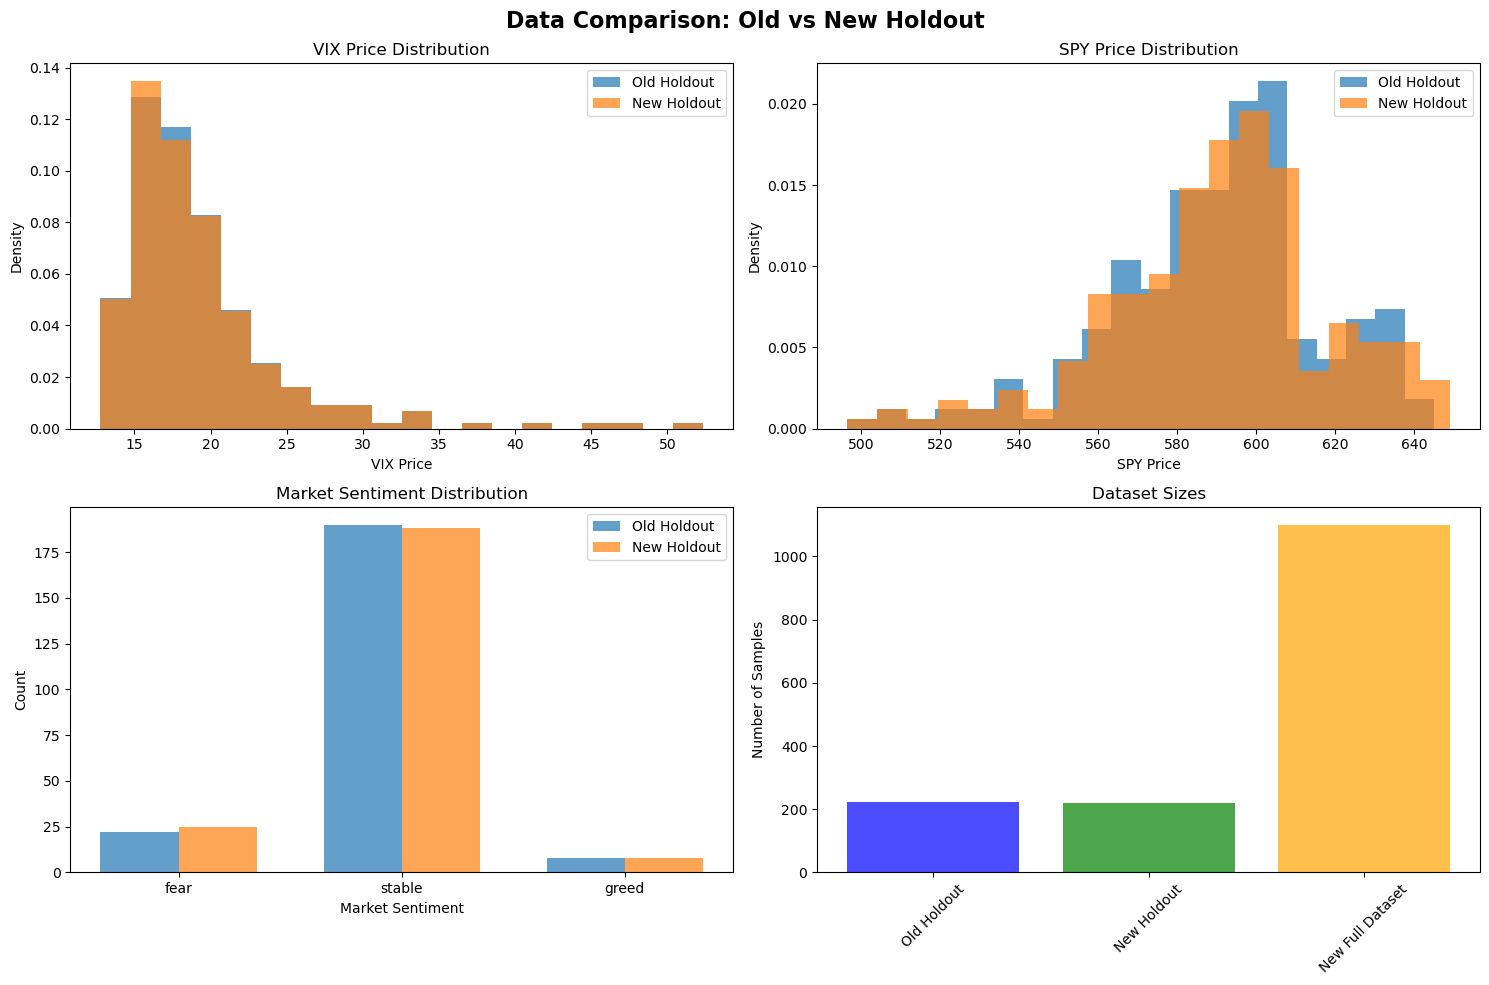

📊 Summary Statistics Comparison

SPY_Price:
  Old Holdout: Mean=589.63, Std=27.13
  New Holdout: Mean=590.53, Std=27.76
  Mean Change: 0.15%

VIX_Price:
  Old Holdout: Mean=19.34, Std=5.60
  New Holdout: Mean=19.31, Std=5.60
  Mean Change: -0.18%

QQQ_Price:
  Old Holdout: Mean=512.16, Std=32.09
  New Holdout: Mean=513.13, Std=32.57
  Mean Change: 0.19%

SPY_Volatility:
  Old Holdout: Mean=0.17, Std=0.12
  New Holdout: Mean=0.17, Std=0.12
  Mean Change: -0.11%


In [15]:
# Quick visualization of key differences
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Data Comparison: Old vs New Holdout', fontsize=16, fontweight='bold')

# Plot 1: VIX Price distribution
if 'VIX_Price' in old_holdout.columns and 'VIX_Price' in new_holdout.columns:
    axes[0,0].hist(old_holdout['VIX_Price'].dropna(), bins=20, alpha=0.7, label='Old Holdout', density=True)
    axes[0,0].hist(new_holdout['VIX_Price'].dropna(), bins=20, alpha=0.7, label='New Holdout', density=True)
    axes[0,0].set_xlabel('VIX Price')
    axes[0,0].set_ylabel('Density')
    axes[0,0].set_title('VIX Price Distribution')
    axes[0,0].legend()

# Plot 2: SPY Price distribution
if 'SPY_Price' in old_holdout.columns and 'SPY_Price' in new_holdout.columns:
    axes[0,1].hist(old_holdout['SPY_Price'].dropna(), bins=20, alpha=0.7, label='Old Holdout', density=True)
    axes[0,1].hist(new_holdout['SPY_Price'].dropna(), bins=20, alpha=0.7, label='New Holdout', density=True)
    axes[0,1].set_xlabel('SPY Price')
    axes[0,1].set_ylabel('Density')
    axes[0,1].set_title('SPY Price Distribution')
    axes[0,1].legend()

# Plot 3: Market Sentiment distribution
if 'Market_Sentiment' in old_holdout.columns and 'Market_Sentiment' in new_holdout.columns:
    old_sentiment = old_holdout['Market_Sentiment'].value_counts()
    new_sentiment = new_holdout['Market_Sentiment'].value_counts()
    
    categories = list(set(old_sentiment.index) | set(new_sentiment.index))
    old_counts = [old_sentiment.get(cat, 0) for cat in categories]
    new_counts = [new_sentiment.get(cat, 0) for cat in categories]
    
    x = np.arange(len(categories))
    width = 0.35
    
    axes[1,0].bar(x - width/2, old_counts, width, label='Old Holdout', alpha=0.7)
    axes[1,0].bar(x + width/2, new_counts, width, label='New Holdout', alpha=0.7)
    axes[1,0].set_xlabel('Market Sentiment')
    axes[1,0].set_ylabel('Count')
    axes[1,0].set_title('Market Sentiment Distribution')
    axes[1,0].set_xticks(x)
    axes[1,0].set_xticklabels(categories)
    axes[1,0].legend()

# Plot 4: Dataset size comparison
dataset_info = {
    'Old Holdout': len(old_holdout),
    'New Holdout': len(new_holdout),
    'New Full Dataset': len(new_data)
}

axes[1,1].bar(range(len(dataset_info)), list(dataset_info.values()), alpha=0.7, color=['blue', 'green', 'orange'])
axes[1,1].set_ylabel('Number of Samples')
axes[1,1].set_title('Dataset Sizes')
axes[1,1].set_xticks(range(len(dataset_info)))
axes[1,1].set_xticklabels(list(dataset_info.keys()), rotation=45)

plt.tight_layout()
plt.show()

# Print summary statistics
print("📊 Summary Statistics Comparison")
print("=" * 50)

numerical_cols = ['SPY_Price', 'VIX_Price', 'QQQ_Price', 'SPY_Volatility']
available_cols = [col for col in numerical_cols if col in old_holdout.columns and col in new_holdout.columns]

for col in available_cols[:4]:  # Limit to first 4 columns
    print(f"\n{col}:")
    print(f"  Old Holdout: Mean={old_holdout[col].mean():.2f}, Std={old_holdout[col].std():.2f}")
    print(f"  New Holdout: Mean={new_holdout[col].mean():.2f}, Std={new_holdout[col].std():.2f}")
    mean_change = ((new_holdout[col].mean() - old_holdout[col].mean()) / old_holdout[col].mean()) * 100
    print(f"  Mean Change: {mean_change:.2f}%")